# Hands-On Machine Learning Project
## Topic 20: Credit Data
### Florian Korn, Vincent Bläske, Dennis Götz

**General comments by FV:**

- Quite good overall!

- You have a Jupyter notebook which allows you to mix text with code, but you nevertheless put a lot of "narrative" into comments at the beginning of the code blocks, instead of in text cells!

- I wrote many notes (marked like this one) all over the notebook. Please read them!

- It was not intended that one conducts formal statistical tests for normality, etc. of the features.

- For training models later on you should think about whether you want to represent the categorical features "as numbers" or as "one-hot encoded" (maybe try both and check what works better). Note that if you choose numerical encoding, you might want to choose the encoding by hand so that the "ordering/numbering" of the values makes sense. See the comments below for more details.

## I. Get the Data
1. Get (download) the data.
2. Convert the data to a format you can easily manipulate (without changing the data itself), e.g. a Pandas
DataFrame.
3. Sample a test set, put it aside, and never look at it (no data snooping!)

**Comment by FV:** It would have been nice to also include the file `german.data-numeric.csv` in your submission to make it self-contained!

In [2]:
# Import libraries
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.stats as stats

# Attributes
attributes = ['Status of existing checking account',
              'Duration in month',
              'Credit history',
              'Purpose',
              'Credit amount', 
              'Savings account/bonds',
              'Present employment since',
              'Installment rate in percentage of disposable income', 
              'Personal status and sex',
              'Other debtors / guarantors',
              'Present residence since',
              'Property',
              'Age in years',
              'Other installment plans',
              'Housing',
              'Number of existing credits at this bank',
              'Job',
              'Number of people being liable to provide maintenance for',
              'Telephone',
              'foreign worker',
              'Credit rating']

# Load original dataset DATA-Format
data = pd.read_csv('german.data', sep=' ', header=None)
data.columns = attributes

# Load numerical dataset CSV-Format
data_num = pd.read_csv('german.data-numeric.csv', sep=';', header=None)

data.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Credit rating
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [3]:
data.info() #many categorical attributes
#data.hist(bins=50, figsize=(25,12));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Status of existing checking account                       1000 non-null   object
 1   Duration in month                                         1000 non-null   int64 
 2   Credit history                                            1000 non-null   object
 3   Purpose                                                   1000 non-null   object
 4   Credit amount                                             1000 non-null   int64 
 5   Savings account/bonds                                     1000 non-null   object
 6   Present employment since                                  1000 non-null   object
 7   Installment rate in percentage of disposable income       1000 non-null   int64 
 8   Personal status and sex      

**Comment by FV:** It would be nice to briefly state that the "real meanings" of the codes are taken from the description of the data set, e.g. [here](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data).

In [4]:
# Create dictionary with real values to make the DataFrame readable

cat_dict = {# Attribute 1: (qualitative) Status of existing checking account 
                    'A11' : '... < 0 DM',
                    'A12' : '0 <= ... < 200 DM',
                    'A13' : '... >= 200 DM / salary assignments for at least 1 year',
                    'A14' : 'no checking account',

                    # Attribute 3: (qualitative) Credit history 
                    'A30' : 'no credits taken/ all credits paid back duly',
                    'A31' : 'all credits at this bank paid back duly',
                    'A32' : 'existing credits paid back duly till now',
                    'A33' : 'delay in paying off in the past',
                    'A34' : 'critical account/ other credits existing (not at this bank)',
                    
                    # Attribute 4: (qualitative) Purpose 
                    'A40' : 'car (new)',
                    'A41' : 'car (used)',
                    'A42' : 'furniture/equipment',
                    'A43' : 'radio/television',
                    'A44' : 'domestic appliances',
                    'A45' : 'repairs',
                    'A46' : 'education',
                    'A47' : '(vacation - does not exist?)',
                    'A48' : 'retraining',
                    'A49' : 'business',
                    'A410' : 'others',

                    # Attibute 6: (qualitative) Savings account/bonds 
                    'A61' : '... < 100 DM',
                    'A62' : '100 <= ... < 500 DM',
                    'A63' : '500 <= ... < 1000 DM',
                    'A64' : '... >= 1000 DM',
                    'A65' : 'unknown/ no savings account',

                    # Attribute 7: (qualitative) Present employment since 
                    'A71' : 'unemployed',
                    'A72' : '... < 1 year',
                    'A73' : '1 <= ... < 4 years',
                    'A74' : '4 <= ... < 7 years',
                    'A75' : '... >= 7 years',

                    # Attribute 9: (qualitative) Personal status and sex 
                    'A91' : 'male : divorced/separated',
                    'A92' : 'female : divorced/separated/married',
                    'A93' : 'male : single',
                    'A94' : 'male : married/widowed',
                    'A95' : 'female : single',

                    # Attribute 10: (qualitative) Other debtors / guarantors 
                    'A101' : 'none',
                    'A102' : 'co-applicant',
                    'A103' : 'guarantor',

                    # Attribute 12: (qualitative) Property 
                    'A121' : 'real estate',
                    'A122' : 'if not A121 : building society savings agreement/ life insurance',
                    'A123' : 'if not A121/A122 : car or other, not in attribute 6',
                    'A124' : 'unknown / no property',

                    # Attribute 14: (qualitative) Other installment plans 
                    'A141' : 'bank',
                    'A142' : 'stores',
                    'A143' : 'none',

                    # Attribute 15: (qualitative) Housing 
                    'A151' : 'rent',
                    'A152' : 'own',
                    'A153' : 'for free',

                    # Attribute 17: (qualitative) Job
                    'A171' : 'unemployed/ unskilled - non-resident',
                    'A172' : 'unskilled - resident',
                    'A173' : 'skilled employee / official',
                    'A174' : 'management/ self-employed/ highly qualified employee/ officer',

                    # Attribute 19: (qualitative) Telephone
                    'A191' : 'none',
                    'A192' : 'yes, registered under the customers name',

                    # Attribute 20: (qualitative) foreign worker 
                    'A201' : 'yes',
                    'A202' : 'no',

                    # Target value: (qualitative) Credit rating
                    1 : 'good',
                    2 : 'bad'
                    }

In [5]:
# Qualitative attributes
cat_attribs = ['Status of existing checking account',
               'Credit history',
               'Purpose',
               'Savings account/bonds', 
               'Present employment since',
               'Personal status and sex',
               'Other debtors / guarantors',
               'Property',
               'Other installment plans',
               'Housing',
               'Job',
               'Telephone',
               'foreign worker',
               'Credit rating']

# Numerical attributes
num_attribs = list(set(attributes) - set(cat_attribs))

# Copy the data to a new DataFrame
data_values = data.copy()

# Apply the dictionary to all categorical attributes of the new DataFrame to get the real values
data_values[cat_attribs] = pd.DataFrame([data_values[attribute].apply(lambda key: cat_dict[key]) for attribute in cat_attribs]).T

# Save new DataFrame as XLSX
data_values.to_excel('data_values.xlsx')
data_values.head(3)

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Credit rating
0,... < 0 DM,6,critical account/ other credits existing (not ...,radio/television,1169,unknown/ no savings account,... >= 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,good
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,bad
2,no checking account,12,critical account/ other credits existing (not ...,education,2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,good


**Minor comment by FV:** Instead of `[:, :20]`, one could also use `[:, :-1]`.

In [6]:
# Create a Test Set
train_set, test_set = train_test_split(data_values, train_size=0.8, random_state=0, stratify=data_values['Credit rating'])

# Separate features and target values in train and test set
X_train = np.array(train_set.iloc[:, :20])
y_train = np.array(train_set.iloc[:, -1])
X_test = np.array(test_set.iloc[:, :20])
y_test = np.array(test_set.iloc[:, -1])

print(f'{X_train.shape = }')
print(f'{X_test.shape = }\n')

# Check if training and test set have the same target-value-ratio
print('Ratio of target value good (1) in y_train: {:.2f} %'.format(100*np.sum(y_train == 'good')/len(y_train)))
print('Ratio of target value good (1) in y_test: {:.2f} %'.format(100*np.sum(y_test == 'good')/len(y_test)))

X_train.shape = (800, 20)
X_test.shape = (200, 20)

Ratio of target value good (1) in y_train: 70.00 %
Ratio of target value good (1) in y_test: 70.00 %


**Comment by FV:** I added the parameter `dtype='int'`, so that the encoded values for the categorical features are saved as integers, rather than floats.

In [7]:
from sklearn.preprocessing import OrdinalEncoder

# Handling Text and Categorical Attributes (gleiches Ergebnis wie bei Flo! Nur haben sind die Attribute unterschiedlich nummeriert.)
data_cat = train_set[cat_attribs]

ordinal_encoder = OrdinalEncoder(dtype='int') # modified by FV
data_cat_encoded = ordinal_encoder.fit_transform(data_cat)

# Replace the categories by numbers
data_encoded = train_set.copy()
data_encoded[cat_attribs] = data_cat_encoded
data_encoded.head(3)

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Credit rating
355,2,24,3,1,1246,0,0,4,3,2,...,2,23,2,1,1,3,1,0,1,0
661,0,12,3,1,900,4,2,4,2,2,...,1,23,1,1,1,1,1,0,1,0
300,3,6,3,1,672,0,4,1,0,2,...,2,54,1,1,1,2,1,1,1,1


In [8]:
# Create a list with a dictionary for each categorical feature with the encoded and real values
encoder_list = []

for feature in range(len(ordinal_encoder.categories_)):
    encoder_dict = dict()
    for index, category in enumerate(ordinal_encoder.categories_[feature]):
        encoder_dict[index] = category
    encoder_list.append(encoder_dict)

# How to select a dictionary of a given feature
encoder_list[cat_attribs.index('Status of existing checking account')]

{0: '... < 0 DM',
 1: '... >= 200 DM / salary assignments for at least 1 year',
 2: '0 <= ... < 200 DM',
 3: 'no checking account'}

**Comment by FV:**
- The below code is a bit strange, since the action of the `label_encoder` function is different from the action of the `LabelEncoder` from sklearn. Is this intended this way? The issue is that the `LabelEncoder` numbers the unique elements "in increasing order", while your code numbers the unique elements "in the order in which they appear in the data". To see the difference, consider the following code snippet.

- The other question is why you don't simply use the `LabelEncoder` directly instead of writing a function around it that does a similar, but slightly different thing.

In [9]:
# added by FV
series = pd.Series([1, 6, 3, 3])
label_encoder = preprocessing.LabelEncoder()
encoder_val = np.unique(label_encoder.fit_transform(series))
dict_index = series.unique()
dict_label_encoder =  pd.Series(encoder_val, index = dict_index).to_dict()

print("return value of `label_encoder`:\n", series.map(dict_label_encoder))
print("encoded value using `LabelEncoder:`", label_encoder.transform(series))

return value of `label_encoder`:
 0    0
1    1
2    2
3    2
dtype: int64
encoded value using `LabelEncoder:` [0 2 1 1]


In [10]:
# Change features into dummy variables (one-hot-encoding)
#data_values_dummies = pd.get_dummies(data_values)

# Change features into label encoding
def label_encoder(series):
    label_encoder = preprocessing.LabelEncoder()
    encoder_val = np.unique(label_encoder.fit_transform(series))
    dict_index = series.unique()
    dict_label_encoder =  pd.Series(encoder_val, index = dict_index).to_dict()
    return series.map(dict_label_encoder), dict_label_encoder

data_values_dummies = pd.DataFrame()
all_dict = []
for i in range(len(data_values.columns)):
    if data_values.columns[i] in cat_attribs:
        data_values_dummies[i], dict_temp = label_encoder(data_values.iloc[:,i])
        all_dict.append(dict_temp)
    else:
        data_values_dummies[i] = data_values.iloc[:,i]

data_values_dummies.columns = data_values.columns

# # Separate features and target values
# features = np.array(data_values_dummies.iloc[:, :20])
# target_values = np.array(data_values_dummies.iloc[:, -1])

# # Split the dataset into training- and testset (goog/bad ratio stays the same)
# X_train, X_test, y_train, y_test = train_test_split(features, target_values, train_size=0.8, random_state=0, stratify=target_values)

# print(f'{X_train.shape = }')
# print(f'{X_test.shape = }\n')

# # Check if training and test set have the same target-value-ratio
# print('Ratio of target value good (0) in y_train: {:.2f} %'.format(100*np.sum(y_train == 0)/len(y_train)))
# print('Ratio of target value good (0) in y_test: {:.2f} %'.format(100*np.sum(y_test == 0)/len(y_test)))

In [11]:
set(data_values['Purpose'])

{'business',
 'car (new)',
 'car (used)',
 'domestic appliances',
 'education',
 'furniture/equipment',
 'others',
 'radio/television',
 'repairs',
 'retraining'}

**One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values.** (book chapter p.72)

This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, and “excellent”), but it is obviously not the case for the purpose column (for example, categories 0 and 1 aren't more similar than categories 0 and 4). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is "car (new)" (and 0 otherwise), another attribute equal to 1 when the category is "car (used)" (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes.


**Comment by FV:**
- It could make sense to manually decide for each feature if the "ordering" of the categories makes sense (or can be made to make sense). For instance, for the "Job" variable, it seems that an ordering from "less qualified/employed" to "more qualified/employed" could make sense. Similar things seem to hold for
  - status of existing checking account
  - Savings account/bonds
  - Present employment since
For these features, one could then decide to NOT one-hot encode them, but leave them as is.

- Furthermore, features that are already binary (such as "foreign worker" and "telephone", and the target variable "credit rating") should not be "one-hot encoded again".

In [12]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(dtype='int') # argument added by FV
data_cat_1hot = cat_encoder.fit_transform(data_cat)

data_cat_dummies = pd.DataFrame(data_cat_1hot.toarray(),
                                columns=cat_encoder.get_feature_names_out(), #generate new column names with category as suffix to the attribute
                                index=data_cat.index) #keep old indices
data_cat_dummies # this has no effect (comment by FV)

# Merge the DataFrames
data_dummies = train_set[num_attribs].copy()
data_dummies = pd.merge(left=data_dummies, right=data_cat_dummies, left_index=True, right_index=True)
data_dummies.head()

,Present residence since,Credit amount,Age in years,Number of existing credits at this bank,Duration in month,Number of people being liable to provide maintenance for,Installment rate in percentage of disposable income,Status of existing checking account_... < 0 DM,Status of existing checking account_... >= 200 DM / salary assignments for at least 1 year,Status of existing checking account_0 <= ... < 200 DM,...,Job_management/ self-employed/ highly qualified employee/ officer,Job_skilled employee / official,Job_unemployed/ unskilled - non-resident,Job_unskilled - resident,Telephone_none,"Telephone_yes, registered under the customers name",foreign worker_no,foreign worker_yes,Credit rating_bad,Credit rating_good
355,2,1246,23,1,24,1,4,0,0,1,...,0,0,0,1,1,0,0,1,1,0
661,2,900,23,1,12,1,4,1,0,0,...,0,1,0,0,1,0,0,1,1,0
300,4,672,54,1,6,1,1,0,0,0,...,0,0,1,0,0,1,0,1,0,1
916,2,2848,32,1,10,2,1,0,0,0,...,0,1,0,0,1,0,0,1,0,1
294,2,7629,46,2,48,2,4,0,0,0,...,1,0,0,0,1,0,0,1,0,1


In [13]:
# added by FV
print(data_dummies.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 355 to 439
Data columns (total 63 columns):
 #   Column                                                                                      Non-Null Count  Dtype
---  ------                                                                                      --------------  -----
 0   Present residence since                                                                     800 non-null    int64
 1   Credit amount                                                                               800 non-null    int64
 2   Age in years                                                                                800 non-null    int64
 3   Number of existing credits at this bank                                                     800 non-null    int64
 4   Duration in month                                                                           800 non-null    int64
 5   Number of people being liable to provide maintenance fo

## II. Frame the Problem and Look at the Big Picture
1. Define the objective:<br>
a) Create a model that predicts the target value if a new sample has a 'good' or 'bad' credit rating.<br>
b) Most important features for credit rating? Reliability.<br>
c) Can a SMOTE algorithm improve the performance of the model (balanced dataset)?<br>
d) Can forward/backward selection improve the performance of the model?<br>
e) How well are Regression-Models performing with the categorical data (1hotEncoding)?<br>

2. How should you frame this problem (supervised/unsupervised, regression/classification, etc)<br>
supervised, classification problem
3. How should performance be measured?<br>
Accuracy, AUC, ROC, F1-Score, GMean, Precision, Recall, R², MAE, MSE<br>
It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1). (FP worse than FN!!)<br>
4. What would be the minimum performance needed to reach the objective?<br>
At least 70% accuracy.
5. How would you solve the problem manually?<br>
Look how often a credit has a bad credit score if certain criterias are met. Depending on the characteristics of a new borrower we would assign good or bad credit risk.

**Comments by FV:**

- Regarding 1: I think it would be cool to include these "extra" things like SMOTE and forward/backward, but **if you really use these, you should also explain in your presentation what these do!**

- Regarding 3: You did not say this explicitly, but it seems that you are taking "good (credit rating)" as the positive class. It might make more sense to choose "bad" as the positive class (the thing we want to detect). Then, given the "cost matrix", recall (well identifying people with a "bad" credit rating as bad) would be more important than precision.

- Regarding 4: 70% accuracy is very easy, since one gets this by always predicting "good". Or is that what you want to say? I think the question was more in the direction of "Imagine you are really working for a bank. What accuracy/precision/recall would be enough to (maybe) use your model 'in production'?"

- Regarding 5: This is still a bit vague, but this was also not really required.

## III. Explore the Data
1. Create a copy of the data for exploration (sampling it down to a manageable size if necessary).
2. Recommended: Create a Jupyter notebook to keep a record of your data exploration.
3. Study each attribute and its characteristics:<br>
◦ Name<br>
◦ Type (categorical, int/float, bounded/unbounded, text, etc.)<br>
◦ % of missing values<br>
◦ Noisiness and type of noise (e.g. stochastic, outliers, rounding errors, etc.)<br>
◦ Usefulness for the task<br>
◦ Type of distribution (Gaussian, uniform, logarithmic, etc.) [Feel free to omit this for the projectsfor this lecture]
4. For supervised learning tasks, identify the target attribute(s).
5. Visualize the data.
6. Study the correlations between attributes and in particular between the "feature attributes" and the target attribute.
7. Study how you would solve the problem manually.
8. Identify promising transformations (feature engineering) you may want to apply.
9. Document what you have learned

In [14]:
# Check for NA-values
print('NA values: {}\n'.format(np.sum(np.sum(train_set.isna()))))

# Check rate of target values
print('{}\n'.format(train_set['Credit rating'].value_counts())) #slightly imbalanced; most of samples have a 'good' or '1' credit rating!

# Check data types of encoded DF
data_encoded.info() #no objects anymore!

NA values: 0

good    560
bad     240
Name: Credit rating, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 355 to 439
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype
---  ------                                                    --------------  -----
 0   Status of existing checking account                       800 non-null    int64
 1   Duration in month                                         800 non-null    int64
 2   Credit history                                            800 non-null    int64
 3   Purpose                                                   800 non-null    int64
 4   Credit amount                                             800 non-null    int64
 5   Savings account/bonds                                     800 non-null    int64
 6   Present employment since                                  800 non-null    int64
 7   Installment rate in percentage of disposable incom

**Comment by FV:** Given the "encoded" data, one could also apply things like `describe` and `pairplot` to these features (it would maybe make a little less sense, but could still be useful, in particular for the `pairplot`).

In [15]:
# Get some statistics from numerical attributes
train_set.describe()

,Duration in month,Credit amount,Installment rate in percentage of disposable income,Present residence since,Age in years,Number of existing credits at this bank,Number of people being liable to provide maintenance for
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,20.916250,3247.860000,2.970000,2.863750,35.438750,1.408750,1.145000
std,11.997465,2775.170745,1.121683,1.099635,11.475991,0.574095,0.352321
min,4.000000,276.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1363.250000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2281.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3965.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,15945.000000,4.000000,4.000000,75.000000,4.000000,2.000000


**Comment by FV:**

- In order to avoid [overplotting](https://www.python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/) at least to some extent, one can add a bit of jitter to the features that have only few different values, and in addition add an `alpha` parameter to the plot. See the code below for details.

- It would also be good to prevent the different labels from overlapping!

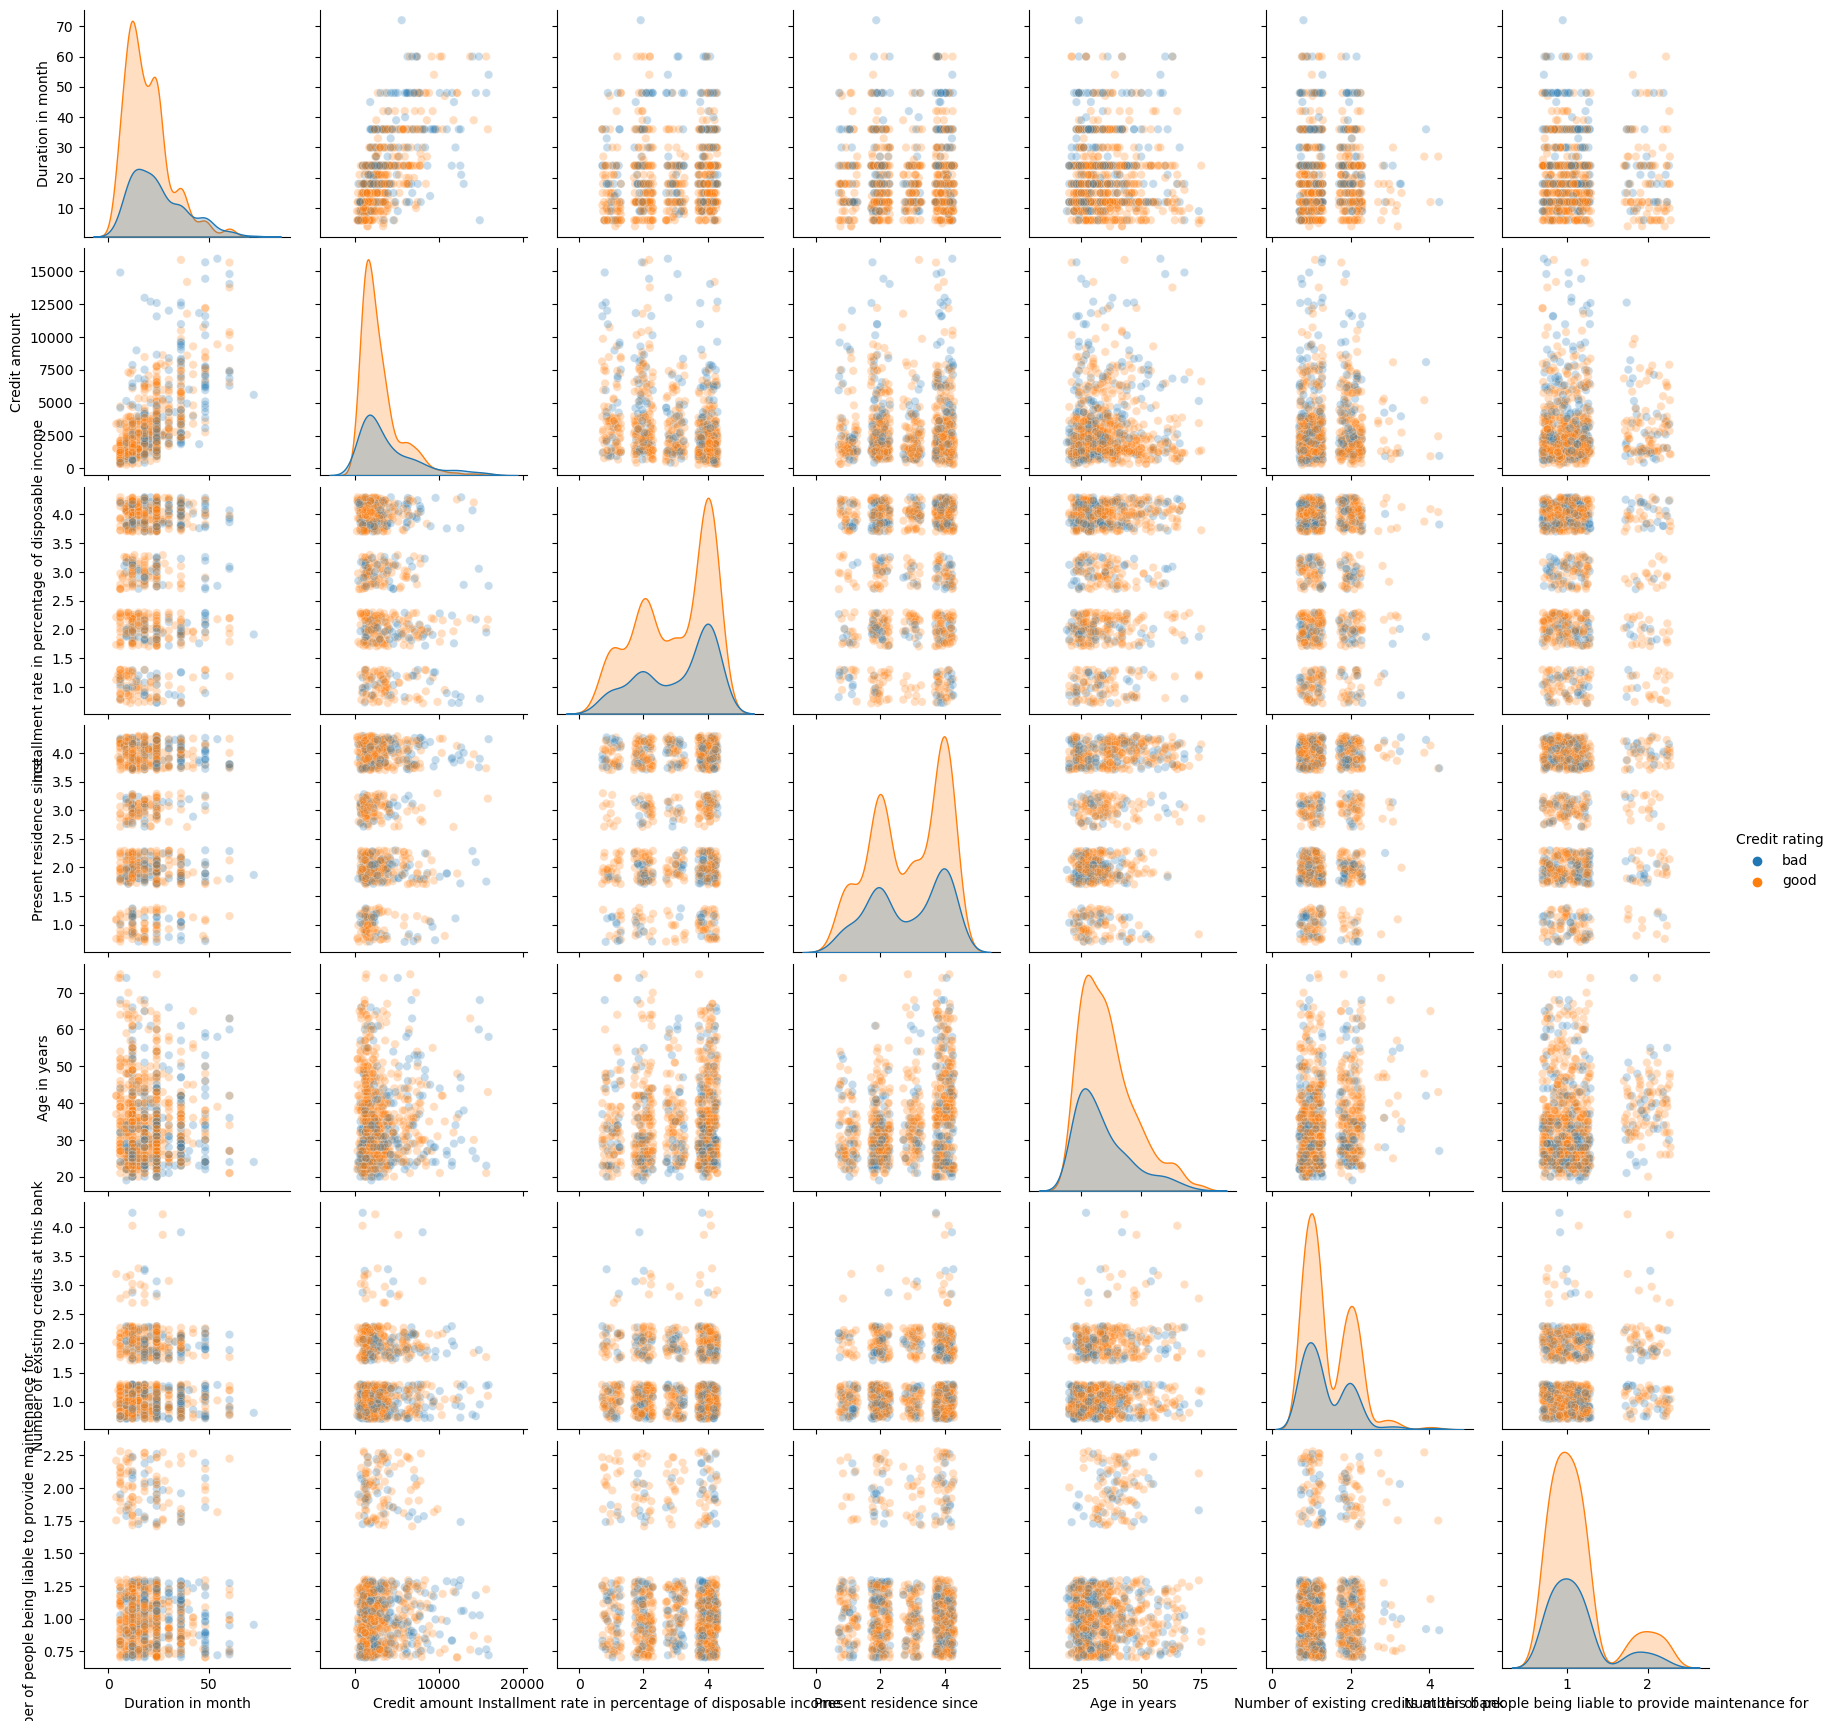

In [16]:
# Pairplotting the numerical columns
# scatter_matrix(data_train, c=y_train, figsize=(30,30), marker='o',
#                hist_kwds={'bins': 15}, s=30);

# code heavily modified by FV

plot_set = train_set.copy()
discrete_attributes = ["Installment rate in percentage of disposable income",
                       "Present residence since",
                       "Number of existing credits at this bank",
                       "Number of people being liable to provide maintenance for"]

n_rows = plot_set.shape[0]

for attr in discrete_attributes:
    plot_set[attr] += np.random.uniform(-0.3, 0.3, size=(n_rows))

sns.pairplot(plot_set, markers='o', hue='Credit rating', plot_kws={'alpha' : 0.25})
plt.show()

**Comment by FV:** It would be nicer to have a plot for the correlation, as for instance generated by the following code.

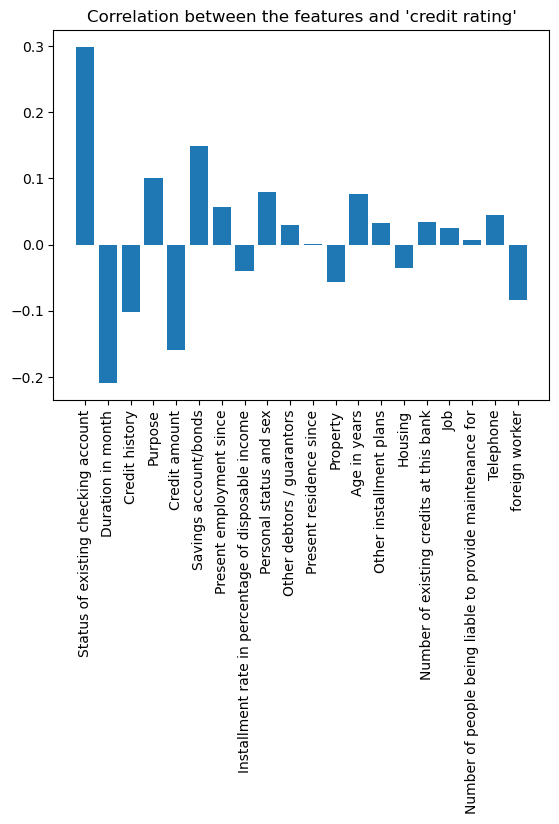

In [24]:
corrs = data_encoded.corr()["Credit rating"]

plt.bar(corrs.index[:-1], corrs[:-1])

plt.title("Correlation between the features and 'credit rating'")
plt.xticks(rotation = 90)

plt.show()

In [17]:
# Correlation between features and target value
data_encoded.corr()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Credit rating
Status of existing checking account,1.000000,-0.031613,-0.079126,0.045993,-0.000178,0.229399,0.021468,0.010309,0.028399,0.108710,...,0.000713,0.037552,0.013955,-0.035818,0.107635,-0.040515,-0.023078,0.062793,0.066360,0.298544
Duration in month,-0.031613,1.000000,0.023706,-0.108870,0.642156,0.051646,0.044137,0.054777,0.100410,-0.012325,...,0.098192,-0.032730,-0.022567,-0.145666,-0.001020,-0.203948,-0.020219,0.143177,0.141435,-0.209096
Credit history,-0.079126,0.023706,1.000000,0.016792,0.032403,-0.031783,-0.053400,-0.070392,-0.062053,0.022348,...,-0.069497,-0.155582,0.065954,0.095886,-0.370501,-0.015657,-0.088282,-0.037597,0.008833,-0.101499
Purpose,0.045993,-0.108870,0.016792,1.000000,-0.204144,-0.023026,-0.041280,0.137292,-0.054711,-0.071717,...,-0.012708,-0.061511,0.038791,0.010090,-0.040576,0.031052,-0.080641,-0.127389,0.077639,0.101143
Credit amount,-0.000178,0.642156,0.032403,-0.204144,1.000000,0.062974,0.087849,-0.282387,0.125652,-0.029208,...,0.116886,0.034462,-0.057577,-0.133618,0.014178,-0.242163,0.008207,0.236090,0.067705,-0.159488
Savings account/bonds,0.229399,0.051646,-0.031783,-0.023026,0.062974,1.000000,0.020518,-0.005420,0.041357,0.063955,...,-0.018550,0.044603,-0.042684,-0.025855,-0.011003,-0.033001,0.043271,0.059604,0.009018,0.148335
Present employment since,0.021468,0.044137,-0.053400,-0.041280,0.087849,0.020518,1.000000,-0.085375,0.071700,-0.041001,...,0.008683,0.024768,0.031132,-0.045470,-0.009236,-0.074711,-0.051254,0.036803,0.027115,0.056102
Installment rate in percentage of disposable income,0.010309,0.054777,-0.070392,0.137292,-0.282387,-0.005420,-0.085375,1.000000,0.076752,0.008396,...,0.034810,0.063639,0.023906,-0.079890,0.021010,-0.077013,-0.080821,0.015023,0.090264,-0.039420
Personal status and sex,0.028399,0.100410,-0.062053,-0.054711,0.125652,0.041357,0.071700,0.076752,1.000000,-0.016316,...,0.090941,0.159673,0.000636,-0.248794,0.112661,-0.038207,0.227204,0.047623,-0.059087,0.079574
Other debtors / guarantors,0.108710,-0.012325,0.022348,-0.071717,-0.029208,0.063955,-0.041001,0.008396,-0.016316,1.000000,...,-0.051037,0.024062,0.024440,-0.054864,0.027373,-0.032910,0.007391,0.059450,0.140796,0.028835


**Comment by FV:**
- You raise a good point with the "equal-valued distances".
- The output is a bit weird, since it prints **the absolute value of the correlation** (which one should use for the sorting, as you do), instead of the correlation itself!

In [257]:
# top 5 (positive and negative) correlations between target variable and features
# Prerequisite: categorical features like "status of existing checking account", "credit history", ... are equally interpretable between categories
# example: '... < 0 DM': 0, '0 <= ... < 200 DM': 1, 'no checking account': 2, '... >= 200 DM / salary assignments for at least 1 year': 3
#          difference between 0 (< 0 DM) and 1 (0 <= x < 200 DM) are equally valued as distance (not easy to interpret as they are not numerical value)

top5_correlation_feat = pd.DataFrame(data_encoded.corr().iloc[:-1, -1].abs().sort_values(ascending = False).head(5))
top5_correlation_feat

# Objectives to check in the model:
# - Does the status of the checking account influence if the credit gets a good or bad credit rating?
# - Does the duration of the credit determine if the credit gets a good or bad credit rating?
# - Does the credit amount determines if the credit gets a good or bad credit rating?
# - Does the amount of Savings account/bonds determine if the credit gets a good or bad credit rating?
# - Does the credit history determine if the credit gets a good or bad credit rating?

,Credit rating
Status of existing checking account,0.298544
Duration in month,0.209096
Credit amount,0.159488
Savings account/bonds,0.148335
Credit history,0.101499


In [258]:
# Noiseiness
data_encoded.describe()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Credit rating
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,1.767500,20.916250,2.221250,3.890000,3247.860000,1.177500,1.708750,2.970000,1.861250,1.853750,...,1.342500,35.438750,0.912500,1.087500,1.408750,1.286250,1.145000,0.400000,0.963750,0.700000
std,1.236064,11.997465,1.072957,2.741769,2775.170745,1.593477,1.123834,1.121683,1.361733,0.463821,...,1.000723,11.475991,0.415403,0.529334,0.574095,0.943623,0.352321,0.490204,0.187029,0.458544
min,0.000000,4.000000,0.000000,0.000000,276.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,19.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,12.000000,1.000000,1.000000,1363.250000,0.000000,1.000000,2.000000,0.000000,2.000000,...,1.000000,27.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,2.000000,18.000000,3.000000,5.000000,2281.500000,0.000000,2.000000,3.000000,3.000000,2.000000,...,1.000000,33.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,3.000000,24.000000,3.000000,7.000000,3965.250000,2.000000,2.000000,4.000000,3.000000,2.000000,...,2.000000,42.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,3.000000,72.000000,4.000000,9.000000,15945.000000,4.000000,4.000000,4.000000,3.000000,2.000000,...,3.000000,75.000000,2.000000,2.000000,4.000000,3.000000,2.000000,1.000000,1.000000,1.000000


# Analysis of Features
**Status of existing checking account**<br>
* categorical / nominal<br>
* 0 % missing<br>
* Noisiness and distribution are hard to interpret as it is a categorical value<br>
* Seems usefull, as it has the highest correlation with the target variable of all features<br>
* Category 0 and 2 are equally represented in the data, class 3 is stronger represented than class 0 + 2 and class 1 is strongly underrepresented<br>
    * Interpretation: the accounts of 314 people weren't checked, around 220 people each have 0 or less / between 0 and 200 and 50 people have more than 200<br>
* High probability of getting a 'good' credit rating especially for category 3 ('no checking account') with 88%<br>
* We can't find evidence that the variables are normal, uniform or gamma distributed

**Comment by FV:**
- Regarding "the accounts of 314 people weren't checked": "Checking account" means "Girokonto". Not having one is very different from "people weren't checked"!
- The numbering of the feature is quite weird: 0 for a negative balance, 1 for at least 200 DM, and 2 for "between 0 and 200 DM". It is surprising that the correlation is nevertheless so high!
- In view of the above: please choose a "semantically meaningful" numerical encoding of the feature values (or use one-hot encoding)!

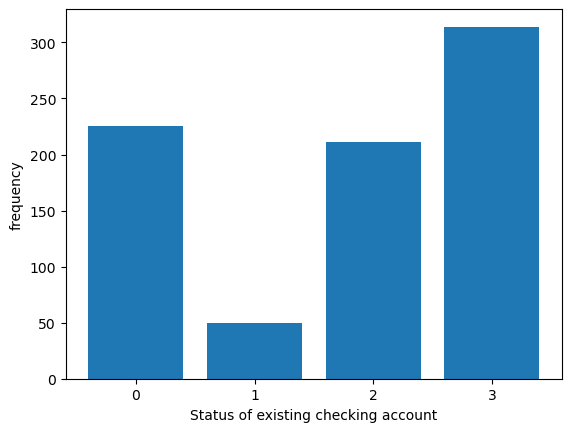

{0: '... < 0 DM',
 1: '... >= 200 DM / salary assignments for at least 1 year',
 2: '0 <= ... < 200 DM',
 3: 'no checking account'}

Status of existing checking account                   
... < 0 DM                                                0.51
... >= 200 DM / salary assignments for at least 1 year    0.80
0 <= ... < 200 DM                                         0.62
no checking account                                       0.88
dtype: float64


In [31]:
# Explore Feature "Status of existing checking account"
fig, ax = plt.subplots()
ax.bar(range(len(data_encoded.iloc[:, 0].value_counts().values)), data_encoded.iloc[:, 0].value_counts().sort_index().values)
plt.xticks(range(len(data_encoded.iloc[:, 0].value_counts().values)))
plt.xlabel('Status of existing checking account')
plt.ylabel('frequency')
plt.show()

# View real values in the dictionary
display(encoder_list[cat_attribs.index('Status of existing checking account')])

#Test (value counts on whole dataset)
#train_set.iloc[:, 0].value_counts()

# Define a function to get the probability of a good rating for each poosible category of a given feature
def good_proba(feature):
    proba_good = np.round(train_set[train_set['Credit rating'] == 'good'][[feature]].value_counts(sort=False)/train_set[[feature]].value_counts(sort=False), 2)
    print(proba_good)

# Calculate the probability of getting a 'good' credit rating for each category
good_proba('Status of existing checking account')

**Comment by FV:** The following generates the same information as those computed by `good_proba`, but in a plot!

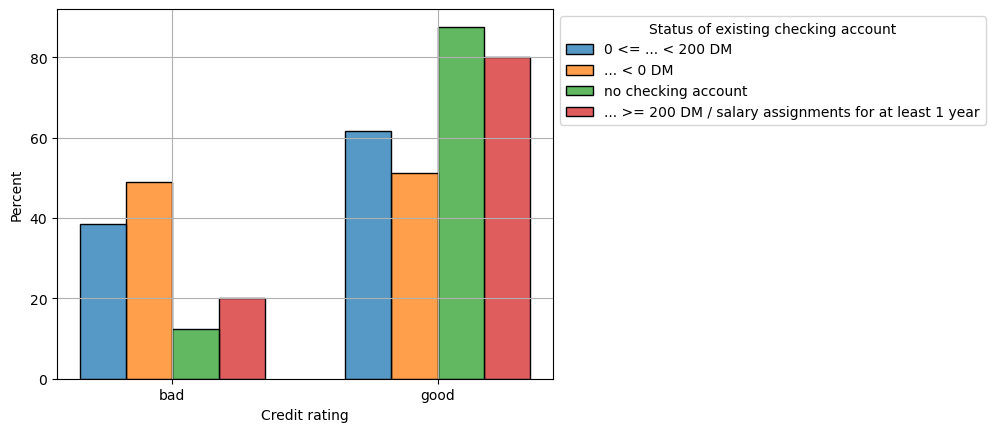

In [30]:
# read the documentation to see what exactly the following code does!
hist = sns.histplot(data=train_set,
                    hue="Status of existing checking account",
                    stat='percent',
                    common_norm=False,
                    bins=4,
                    shrink=0.7,
                    discrete=True,
                    x="Credit rating",
                    multiple='dodge')

sns.move_legend(hist, "upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

**Comment by FV:** **I am not really an expert in statistics**, but I am doubtful if the below code (and the way you apply it later) makes complete sense. Reasons:

- At least for some of the data you are testing (e.g."Status of existing checking account"), the values are discrete, so that the data is obviously not normal or gamma distributed.

- For distributions that are discrete/categorical (finite number of possible values), you are not really testing for a normal/gamma distribution, but rather for the distribution that arises by "projecting/rounding" the outcomes of a normal/gamma distribution to the finite set of possible values.

- For data that is not categorical (such as the "credit amount"), one should [bin](https://en.wikipedia.org/wiki/Data_binning) the data to a not too large number of bins before one applies the $\chi^2$ test. You are currently treating each value occuring in the data as a separate bin (as far as I can tell).

- In case where the test **fails to reject the null hypothesis**, you output "the data is XYZ-distributed". This is not a valid statistical phrasing. It is only true to say that the test did not reject the null hypothesis that the data follows the given distribution.

- I think it would be better to use a [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) or a [Shapiro–Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) (the latter for the normal distribution).

- I don't think that the "degrees of freedom" are completely correctly calculated for the normal and Gamma distribution (see [here](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#Other_distributions)).

Finally, there was a reason that I wrote that you can omit this step (checking the distribution) for this project. It is not too useful, and what was intended is that one should just "stare at the histogram" to visually decide what kind of distribution this could (approximately) be. No formal statistical test was intended.

Side remarks:

- the comments always talk about the "probability funciton of normal distribution", or state that you "calculate parameters for normal distribution", even when it should be the uniform or gamma distribution!

In [35]:
# Define functions to check the distributions
x_axis = np.unique(data_encoded.iloc[:, 0])
observed_values = data_encoded.iloc[:, 0].value_counts().sort_index().values

def check_zero(array):
    n = 0
    for i in range(len(array)):
        if array[i] == 0:
            array[i] = 0.01
            n += 0.01
        else:
            if n > 0 and array[i] > n:
                array[i] -= n
                n = 0
    return array    
            
def check_normal(x_values, observed_values, significance_level = 0.05):
    '''
    This function calculates the chi squared test statistic for the normal distribution for a given significance level.
    --- Input ---
    x_values: the categories
    obersved_values: the data grouped in the categories
    significance_level: the alpha for the chi squared critical value calculation

    --- Output ---
    No output, the values are printed to the console
    '''
    # calculate parameters for normal distribution
    N = sum(observed_values)
    mean_obs = sum(x_values * observed_values) / sum(observed_values)
    var_obs = sum(((x_values - mean_obs)**2) * observed_values) / sum(observed_values)
    # calculate probability funciton of normal distribution for given x
    expected_values = [stats.norm.cdf(x_values[i], loc = mean_obs, scale = np.sqrt(var_obs)) for i in range(len(x_values))]
    expected_values_diff = np.diff(expected_values)
    for i in range(1, len(expected_values)):
        if i != len(expected_values) - 1:
            expected_values[i] = expected_values_diff[i - 1]
        else: 
            expected_values[-1] = 1 - sum(expected_values[:-1])
    expected_values = np.array(expected_values) * N
    # Test observed and expected values
    chisquare_data = stats.chisquare(observed_values, expected_values)
    crit = stats.chi2.ppf(q = 1 - significance_level, df = len(x_values)-1)
    # print
    if (chisquare_data[0] <= crit):
        print('The data is normally distributed\nchi squared:' , chisquare_data[0], '\ncritical value is:' , crit)
    else:
        print('The data is NOT normally distributed\nchi squared:' , chisquare_data[0], '\ncritical value is:' , crit)

def check_uniform(x_values, observed_values, significance_level = 0.05):
    '''
    This function calculates the chi squared test statistic for the uniform distribution for a given significance level.
    --- Input ---
    x_values: the categories
    obersved_values: the data grouped in the categories
    significance_level: the alpha for the chi squared critical value calculation

    --- Output ---
    No output, the values are printed to the console
    '''
    # calculate parameters for normal distribution
    N = sum(observed_values)
    # calculate probability funciton of normal distribution for given x
    expected_values = [sum(observed_values) / len(observed_values) for i in range(len(observed_values))]
    # Test observed and expected values
    chisquare_data = stats.chisquare(observed_values, expected_values)
    crit = stats.chi2.ppf(q = 1 - significance_level, df = len(x_values)-1)
    # print
    if (chisquare_data[0] <= crit):
        print('The data is uniformally distributed\nchi squared:' , chisquare_data[0], '\ncritical value is:' , crit)
    else:
        print('The data is NOT uniformally distributed\nchi squared:' , chisquare_data[0], '\ncritical value is:' , crit)

def check_gamma(x_values, observed_values, significance_level = 0.05):
    '''
    This function calculates the chi squared test statistic for the gamma distribution for a given significance level.
    --- Input ---
    x_values: the categories
    obersved_values: the data grouped in the categories
    significance_level: the alpha for the chi squared critical value calculation

    --- Output ---
    No output, the values are printed to the console
    '''
    # calculate parameters for normal distribution
    N = sum(observed_values)
    mean_obs = sum(x_values * observed_values) / sum(observed_values)
    var_obs = sum(((x_values - mean_obs)**2) * observed_values) / sum(observed_values)
    # calculate probability funciton of normal distribution for given x
    a = (mean_obs / np.sqrt(var_obs))**2
    expected_values = [stats.gamma.cdf(x_values[i], a, loc = mean_obs, scale = np.sqrt(var_obs)) for i in range(len(x_values))]
    expected_values_diff = np.diff(expected_values)
    for i in range(1, len(expected_values)):
        if i != len(expected_values) - 1:
            expected_values[i] = expected_values_diff[i - 1]
        else: 
            expected_values[-1] = 1 - sum(expected_values[:-1])
    expected_values = check_zero(expected_values)
    expected_values = np.array(expected_values) * N
    # Test observed and expected values
    chisquare_data = stats.chisquare(observed_values, expected_values)
    crit = stats.chi2.ppf(q = 1 - significance_level, df = len(x_values)-1)
    # print
    if (chisquare_data[0] <= crit):
        print('The data is gamma distributed\nchi squared:' , chisquare_data[0], '\ncritical value is:' , crit)
    else:
        print('The data is NOT gamma distributed\nchi squared:' , chisquare_data[0], '\ncritical value is:' , crit)

# Check the distributions
check_normal(x_axis, observed_values)
print()
check_uniform(x_axis, observed_values)
print()
check_gamma(x_axis, observed_values)

[0 1 2 3]
[225  50 211 314]
The data is NOT normally distributed
chi squared: 517.1651791310704 
critical value is: 7.814727903251179

The data is NOT uniformally distributed
chi squared: 181.21 
critical value is: 7.814727903251179

The data is NOT gamma distributed
chi squared: 9996.660290201093 
critical value is: 7.814727903251179


**Comment by FV:** I am not exactly sure what `check_zero` is supposed to do, but is the below output reasonable (the output is **not** a PMF).

In [36]:
check_zero([1,0])

[1, 0.01]

**Duration in month**<br>
* Numerical / discrete <br>
* 0 % missing<br>
* Seems usefull, as it has the second highest correlation with the target variable of all features<br>
* Shorter durations are more likely to be rated as 'good'<br>
* We can't find evidence that the variables are normal, uniform or gamma distributed


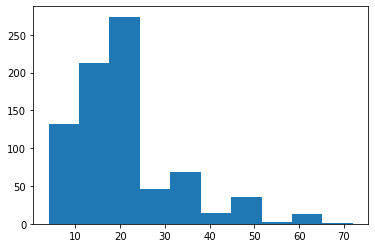

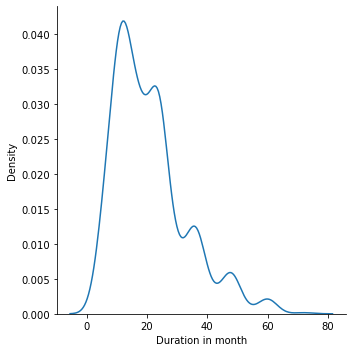

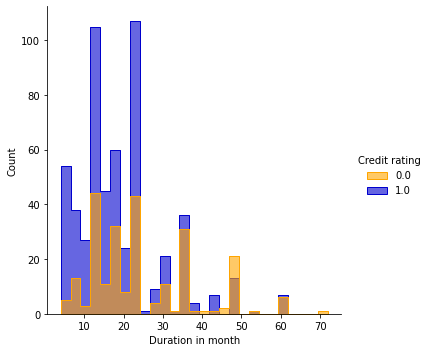

In [261]:
# Explore Feature "Duration in month"
fig, ax = plt.subplots()
ax.hist(data_encoded.iloc[:, 1])
sns.displot(data_encoded.iloc[:, 1], kind = 'kde')

# Plot the feature with target variable as color
rating_palette = {1: 'mediumblue', 0: 'orange'}
sns.displot(data=data_encoded, x='Duration in month', hue='Credit rating', element='step', fill=True, alpha=0.6, palette=rating_palette)
plt.show()


In [37]:
# Check the distributions
x_axis = np.unique(data_encoded.iloc[:, 1])
observed_values = data_encoded.iloc[:, 1].value_counts().sort_index().values

check_normal(x_axis, observed_values)
print()
check_uniform(x_axis, observed_values)
print()
check_gamma(x_axis, observed_values)

The data is NOT normally distributed
chi squared: 2083.7542848236517 
critical value is: 46.19425952027847

The data is NOT uniformally distributed
chi squared: 1938.5875 
critical value is: 46.19425952027847

The data is NOT gamma distributed
chi squared: 19589636.789089333 
critical value is: 46.19425952027847


**Credit amount**<br>
* numerical / continous <br>
* 0 % missing<br>
* Seems usefull, as it has the third highest correlation with the target variable of all features<br>
* Smaller credit amounts are more likely to be rated as 'good'<br>
* We can't find evidence that the variables are normal, uniform or gamma distributed

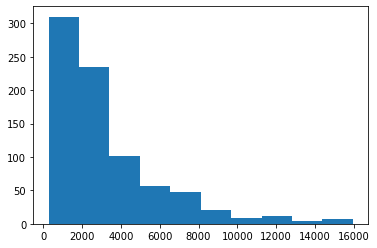

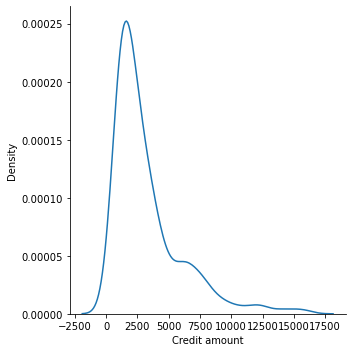

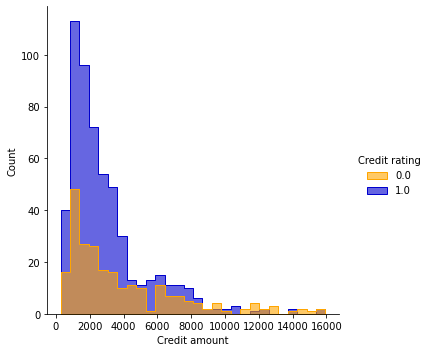

In [270]:
# Explore Feature "Credit amount"
fig, ax = plt.subplots()
ax.hist(data_encoded.iloc[:, 4])
sns.displot(data_encoded.iloc[:, 4], kind = 'kde')

# Plot the feature with the target variable as color
sns.displot(data=data_encoded, x='Credit amount', hue='Credit rating', element='step', fill=True, alpha=0.6, palette=rating_palette)
plt.show()

In [38]:
# Check the distributions
x_axis = np.unique(data_encoded.iloc[:, 4])
observed_values = data_encoded.iloc[:, 4].value_counts().sort_index().values

check_normal(x_axis, observed_values)
print()
check_uniform(x_axis, observed_values)
#check_gamma(x_axis, observed_values)

The data is NOT normally distributed
chi squared: 15733.329824436878 
critical value is: 805.438002972171

The data is uniformally distributed
chi squared: 57.010000000000005 
critical value is: 805.438002972171


**Savings account/bonds**<br>
* categorical / nominal <br>
* 0 % missing<br>
* Seems usefull, as it has the fourth highest correlation with the target variable of all features<br>
* High probability of getting a 'good' credit rating especially for categorys 1 ('... >= 1000 DM') & 4 ('unknown/ no savings account') with 85% or 83% respectively<br>
* We can't find evidence that the variables are normal, uniform or gamma distributed

**Comment by FV:** The numerical encoding of the different categorical values does not make semantic sense! Change the ordering to fix this!

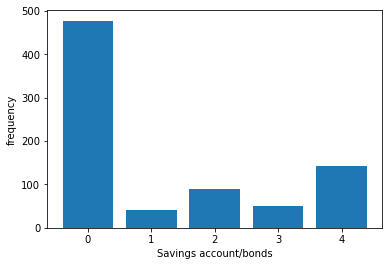

{0: '... < 100 DM',
 1: '... >= 1000 DM',
 2: '100 <= ... < 500 DM',
 3: '500 <= ... < 1000 DM',
 4: 'unknown/ no savings account'}

Savings account/bonds      
... < 100 DM                   0.65
... >= 1000 DM                 0.85
100 <= ... < 500 DM            0.64
500 <= ... < 1000 DM           0.80
unknown/ no savings account    0.83
dtype: float64


In [265]:
# Explore Feature "Savings account/bonds"
fig, ax = plt.subplots()
ax.bar(range(len(data_encoded.iloc[:, 5].value_counts().values)), data_encoded.iloc[:, 5].value_counts().sort_index().values)
plt.xlabel('Savings account/bonds')
plt.ylabel('frequency')
plt.xticks(range(len(data_encoded.iloc[:, 5].value_counts().values)))
plt.show()

# View real values in the dictionary
display(encoder_list[cat_attribs.index('Savings account/bonds')])

# Calculate the probability of getting a 'good' credit rating for each category
good_proba('Savings account/bonds')

**Comment by FV:** Same data as above, as a plot.

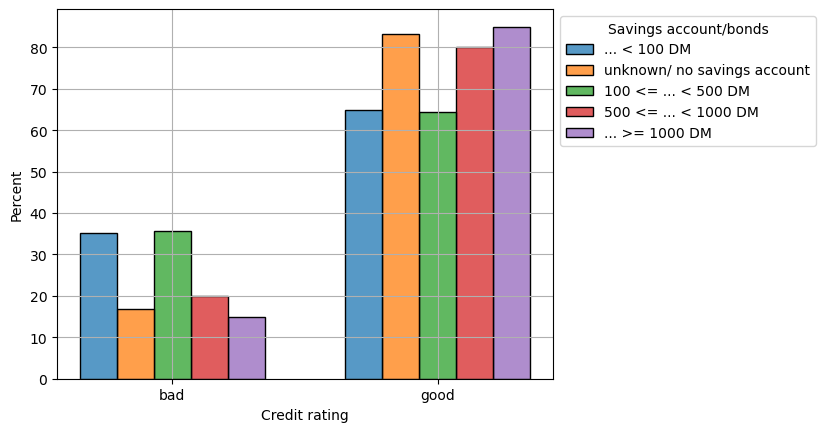

In [39]:
# read the documentation to see what exactly the following code does!
hist = sns.histplot(data=train_set,
                    hue="Savings account/bonds",
                    stat='percent',
                    common_norm=False,
                    bins=4,
                    shrink=0.7,
                    discrete=True,
                    x="Credit rating",
                    multiple='dodge')

sns.move_legend(hist, "upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

In [40]:
# Check the distributions
x_axis = np.unique(data_encoded.iloc[:, 5])
observed_values = data_encoded.iloc[:, 5].value_counts().sort_index().values

check_normal(x_axis, observed_values)
print()
check_uniform(x_axis, observed_values)
print()
check_gamma(x_axis, observed_values)

The data is NOT normally distributed
chi squared: 708.4717613022042 
critical value is: 9.487729036781154

The data is NOT uniformally distributed
chi squared: 826.1125 
critical value is: 9.487729036781154

The data is NOT gamma distributed
chi squared: 28047.951036299553 
critical value is: 9.487729036781154


**Credit history**<br>
* categorical / nominal <br>
* 0 % missing<br>
* Seems usefull, as it has the fifth highest correlation with the target variable of all features<br>
* High probability of getting a 'good' credit rating especially for category 1 ('critical account/ other credits existing (not at this bank)') with 83%<br>
* Low probability of getting a 'good' credit rating especially for category 4 ('no credits taken/ all credits paid back duly') with 34%<br>
* We can't find evidence that the variables are normal, uniform or gamma distributed

**Comment by FV:** The numerical encoding of the different categorical values does not make semantic sense (I think)! Change the ordering to fix this!

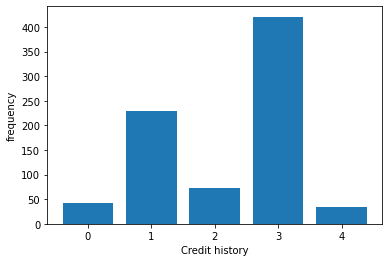

{0: 'all credits at this bank paid back duly',
 1: 'critical account/ other credits existing (not at this bank)',
 2: 'delay in paying off in the past',
 3: 'existing credits paid back duly till now',
 4: 'no credits taken/ all credits paid back duly'}

Credit history                                             
all credits at this bank paid back duly                        0.45
critical account/ other credits existing (not at this bank)    0.83
delay in paying off in the past                                0.71
existing credits paid back duly till now                       0.68
no credits taken/ all credits paid back duly                   0.34
dtype: float64


In [267]:
# Explore Feature "Credit history"
fig, ax = plt.subplots()
ax.bar(range(len(data_encoded.iloc[:, 2].value_counts().values)), data_encoded.iloc[:, 2].value_counts().sort_index().values)
plt.xlabel('Credit history')
plt.ylabel('frequency')
plt.xticks(range(len(data_encoded.iloc[:, 2].value_counts().values)))
plt.show()

# View real values in the dictionary
display(encoder_list[cat_attribs.index('Credit history')])

# Calculate the probability of getting a 'good' credit rating for each category
good_proba('Credit history')

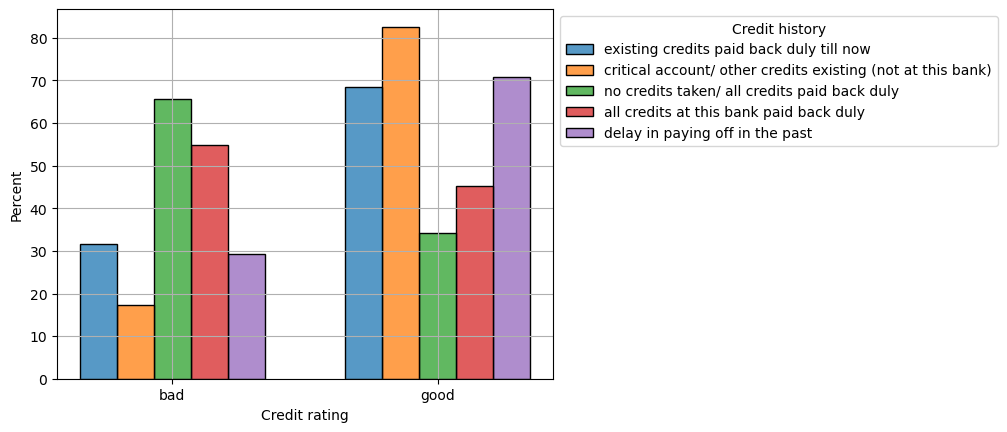

In [42]:
# read the documentation to see what exactly the following code does!
hist = sns.histplot(data=train_set,
                    hue="Credit history",
                    stat='percent',
                    common_norm=False,
                    bins=4,
                    shrink=0.7,
                    discrete=True,
                    x="Credit rating",
                    multiple='dodge')

sns.move_legend(hist, "upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

In [41]:
# Check the distributions
x_axis = np.unique(data_encoded.iloc[:, 2])
observed_values = data_encoded.iloc[:, 2].value_counts().sort_index().values

check_normal(x_axis, observed_values)
print()
check_uniform(x_axis, observed_values)
print()
check_gamma(x_axis, observed_values)

The data is NOT normally distributed
chi squared: 591.838104952647 
critical value is: 9.487729036781154

The data is NOT uniformally distributed
chi squared: 689.4625000000001 
critical value is: 9.487729036781154

The data is NOT gamma distributed
chi squared: 65444.46715675785 
critical value is: 9.487729036781154
